I use this notebook to draw simulationd data from the data generating process. Furthermore, illustrations of the data set as well as the results of a Monte Carlo estimation of changes in skill prices on the basis of simulation data are produced in this notebook.

In [58]:
# import packages
import matplotlib.pyplot as plt
import statsmodels.api as sms
import seaborn as sns
import pandas as pd
import numpy as np
import sys
import os

# import function of DGP
from DGP.draw_data import draw_simulation_data

In [74]:
# Define specifying arguments of DGP.
# This follows the descriptions in my thesis, true change in skill prices in fixed at 0.1.
kwargs = {
          # (1) Arguments for price changing process.
          "pi_fun": "pi_fixed",
          "const": [0.0, 0.1]
          }
# set seed for dgp, number of MC iterations and number of workers
np.random.seed(100)
M = 1000
N = 100

# initialize result arrays
utility_on_mean_lmb = np.empty(M)
adj_wage_on_mean_lmb_previous = np.empty(M)
adj_wage_on_mean_lmb_concurrent = np.empty(M)
wage_on_mean_lmb = np.empty(M)
wage_on_mean_and_diff_lmb_previous = np.empty(M)
wage_on_mean_and_diff_lmb_concurrent = np.empty(M)

# Start MC loop
for m in range(M):
    # Draw simulatioon data following the specification that is described in my thesis.
    sim_data = draw_simulation_data(
        T=3,
        N=N,
        J=2,
        penalty="quad",
        p_weight=15,
        p_locus=(0.3, 0.7),
        p_exponent=2,
        **kwargs
    )

    idx = pd.IndexSlice

    # Calculate mean task choice in base period
    mean_lmb_base = np.array(
        sim_data.loc[idx[0, :], "lambda"].values +
        sim_data.loc[idx[1, :], "lambda"].values
        )/2

    # Calculate chage in task choice in base period
    diff_lmb_base = np.array(
        sim_data.loc[idx[1, :], "lambda"].values -
        sim_data.loc[idx[0, :], "lambda"].values
        )

    # utility change in base period
    util_change_base = np.array(
        sim_data.loc[idx[1, :], "utility"].values -
        sim_data.loc[idx[0, :], "utility"].values
        )

    # wage change in base period
    wage_change_base = np.array(
        sim_data.loc[idx[1, :], "wage"].values -
        sim_data.loc[idx[0, :], "wage"].values
        )

    # Estimate changes in amenities and skill accumulation in base period
    exog_base = pd.DataFrame(data={
        "const": np.ones(N),
        "mean_lmb_base": mean_lmb_base.astype(float),
        "diff_lmb_base": diff_lmb_base.astype(float),
        "lmb_inter_base": mean_lmb_base.astype(float) *
        diff_lmb_base.astype(float),
        "lmb_0": sim_data.loc[idx[0, :], "lambda"].values.astype(float),
        "lmb_0^2": sim_data.loc[idx[0, :], "lambda"].values.astype(float)**2,
        "lmb_1": sim_data.loc[idx[1, :], "lambda"].values.astype(float),
        "lmb_1^2": sim_data.loc[idx[1, :], "lambda"].values.astype(float)**2,
        "mean_lmb_inter_lmb_0": mean_lmb_base.astype(float) *
        sim_data.loc[idx[0, :], "lambda"].values.astype(float),
        "mean_lmb_base_squared": mean_lmb_base.astype(float)**2,
        })

    # (1) Estimate skill accumulation and change in penalty term using task choices in t-1
    OLS_base_period_result_previous = sms.OLS(
        endog=wage_change_base.astype(float),
        exog=exog_base[[
            # "const",
            "lmb_0",
#             "lmb_1",
            "lmb_0^2",
#             "lmb_1^2",
#             "mean_lmb_base",
#             "mean_lmb_base_squared",
            # "diff_lmb_base",
            # "lmb_inter_base"
            ]]
        ).fit()
    
    # (2) Estimate skill accumulation and change in penalty term using task choices in t
    OLS_base_period_result_concurrent = sms.OLS(
        endog=wage_change_base.astype(float),
        exog=exog_base[[
            # "const",
#             "lmb_0",
            "lmb_1",
#             "lmb_0^2",
            "lmb_1^2",
#             "mean_lmb_base",
#             "mean_lmb_base_squared",
            # "diff_lmb_base",
            # "lmb_inter_base"
            ]]
        ).fit()
    
    # Use estimation result to adjust wages changes for skill and
    # amenity changes in subsequent periods

    # Calculate mean task choice in estimation period
    mean_lmb_est = np.array(
        sim_data.loc[idx[2, :], "lambda"].values +
        sim_data.loc[idx[1, :], "lambda"].values
        )/2

    # Calculate chage in task choice in estimation period
    diff_lmb_est = np.array(
        sim_data.loc[idx[2, :], "lambda"].values -
        sim_data.loc[idx[1, :], "lambda"].values
        )

    # wage change in estimation period
    wage_change_est = np.array(
        sim_data.loc[idx[2, :], "wage"].values -
        sim_data.loc[idx[1, :], "wage"].values
        )

    # wage change in estimation period
    util_change_est = np.array(
        sim_data.loc[idx[2, :], "utility"].values -
        sim_data.loc[idx[1, :], "utility"].values
        )

    # Write exogeneous variables into df
    exog_est = pd.DataFrame(data={
        "const": np.ones(N),
        "mean_lmb_est": mean_lmb_est.astype(float),
        "diff_lmb_est": diff_lmb_est.astype(float),
        "lmb_inter_est": mean_lmb_est.astype(float)*diff_lmb_est.astype(float),
        "lmb_1": sim_data.loc[idx[1, :], "lambda"].values.astype(float),
        "lmb_1^2": sim_data.loc[idx[1, :], "lambda"].values.astype(float)**2,
        "lmb_2": sim_data.loc[idx[2, :], "lambda"].values.astype(float),
        "lmb_2^2": sim_data.loc[idx[2, :], "lambda"].values.astype(float)**2,
        "mean_lmb_inter_lmb_1": mean_lmb_est.astype(float) *
        sim_data.loc[idx[1, :], "lambda"].values.astype(float),
        "mean_lmb_est_squared": diff_lmb_est.astype(float)**2,
        })

    # Adjust wage change for predicted changes in skills and amentities
    # (1) using task choices of t-1
    wage_change_est_adjusted_previous = wage_change_est - \
        OLS_base_period_result_previous.predict(
            exog_est[[
#                 "mean_lmb_est",
#                 "mean_lmb_est_squared"
                # "const",
                "lmb_1",
#                 "lmb_2",
                "lmb_1^2",
#                 "lmb_2^2",
                # "diff_lmb_est",
                # "lmb_inter_est"
                ]]
            )
    
    # (2) using task choices of t
    wage_change_est_adjusted_concurrent = wage_change_est - \
        OLS_base_period_result_concurrent.predict(
            exog_est[[
#                 "mean_lmb_est",
#                 "mean_lmb_est_squared"
                # "const",
#                 "lmb_1",
                "lmb_2",
#                 "lmb_1^2",
                "lmb_2^2",
                # "diff_lmb_est",
                # "lmb_inter_est"
                ]]
            )

    # (1) Regress adjusted wage changes on mean_lmb
    pi_tilde_previous = sms.OLS(
        endog=wage_change_est_adjusted_previous.astype(float),
        exog=mean_lmb_est.astype(float)
        ).fit().params.round(6)
    adj_wage_on_mean_lmb_previous[m] = pi_tilde_previous
    
    # (2) Regress adjusted wage changes on mean_lmb
    pi_tilde_previous = sms.OLS(
        endog=wage_change_est_adjusted_concurrent.astype(float),
        exog=mean_lmb_est.astype(float)
        ).fit().params.round(6)
    adj_wage_on_mean_lmb_concurrent[m] = pi_tilde_previous

    

Have a look at the estimation results for the base period

Ideas:
- using t-1 -> positive bias
- in t-1 lambdas are "closer to 0": in a setting where only changes in skill matter and we have learning by doing, people should get better in what they are already doing and focus even more in following period. 
- coeff is smaller here (-0.5)
- 
- using t -> negative bias
- coeff is larger here (-0.48)

Idea:
- actual true parameter is the mean of lambdas of two periods. i.e. it lies in the middel of both. 
- if i now dont use the mean (because I cant due to perfect multicollinearity), i will end up with a result that has either positive or negative bias. True price change lies in the middle.

Have a look at the estimation results for the base period. 
This estimation is used to identify the changes in skill endowments and changes in the penalty term in a base period in absence of changes in skill prices.

Actually, one would need to use the mean value of task choices in t and t-1 as well as the squares of both task choices as regressors. This, however, results in near perfect multicollinearity. Therefore, only task choices of either one of the two periods (t *or* t-1) can be used as regressors. The following regression tables show that either one can fit the wage changes in a base period well.

In [75]:
sms.OLS(
        endog=wage_change_base.astype(float),
        exog=exog_base[[
            # "const",
            "lmb_0",
#             "lmb_1",
            "lmb_0^2",
#             "lmb_1^2",
#             "mean_lmb_base",
#             "mean_lmb_base_squared",
            # "diff_lmb_base",
            # "lmb_inter_base"
            ]]
        ).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          5.720e+04
Date:                Wed, 06 May 2020   Prob (F-statistic):                   4.87e-151
Time:                        23:01:52   Log-Likelihood:                          483.89
No. Observations:                 100   AIC:                                     -963.8
Df Residuals:                      98   BIC:                                     -958.6
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
lmb_0         -0.4989      0.002   -240.382      0.000      -0.503      -0.495
lmb_0^2        1.0001      0.004    278.381      0.000       0.993       1.007
==============================================================================
Omnibus:                       21.728   Durbin-Watson:                   2.085
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.269
Skew:                           0.857   Prob(JB):                     1.09e-09
Kurtosis:                       5.639   Cond. No.                         13.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
sms.OLS(
        endog=wage_change_base.astype(float),
        exog=exog_base[[
            # "const",
#             "lmb_0",
            "lmb_1",
#             "lmb_0^2",
            "lmb_1^2",
#             "mean_lmb_base",
#             "mean_lmb_base_squared",
            # "diff_lmb_base",
            # "lmb_inter_base"
            ]]
        ).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          5.075e+04
Date:                Tue, 05 May 2020   Prob (F-statistic):                   1.71e-148
Time:                        21:17:13   Log-Likelihood:                          478.35
No. Observations:                 100   AIC:                                     -952.7
Df Residuals:                      98   BIC:                                     -947.5
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
lmb_1         -0.4869      0.002   -224.792      0.000      -0.491      -0.483
lmb_1^2        0.9746      0.004    261.100      0.000       0.967       0.982
==============================================================================
Omnibus:                       40.340   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              110.521
Skew:                           1.430   Prob(JB):                     1.00e-24
Kurtosis:                       7.283   Cond. No.                         13.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
pd.set_option('display.max_rows', 500)
sim_data
# wage_change_base

lambda      utility         wage  skills_1  skills_2  \
year individual                                                           
0    0           0.673946   -0.0388232   -0.0387681       0.0 -0.157524   
     1           0.593888     0.198887     0.200792       0.0  0.238097   
     2           0.704473     0.155212     0.156029       0.0  0.121484   
     3             0.5835     0.430029     0.439484       0.0  0.653186   
     4           0.378642    -0.163668    -0.160667       0.0 -0.524325   
     5           0.624817    0.0406492    0.0407199       0.0 -0.034829   
     6           0.702184     0.111852     0.112278       0.0  0.059898   
     7           0.577371  -0.00564655  -0.00564496       0.0 -0.109777   
     8           0.533368     0.176916     0.178789       0.0  0.235207   
     9           0.630076  -0.00675002  -0.00674811       0.0 -0.110710   
     10          0.662292   -0.0323881   -0.0323483       0.0 -0.148843   
     11          0.589492    -0.149116    -0.148064       0.0 -0.351173   
     12          0.476229     0.118855     0.119912       0.0  0.151794   
     13          0.501363     0.513283     0.532053       0.0  0.961214   
     14          0.645767    -0.177922    -0.176674       0.0 -0.373588   
     15          0.648504     0.160666     0.161702       0.0  0.149346   
     16          0.445746 -0.000136846 -0.000136844       0.0 -0.100307   
     17           0.40474     0.242375     0.248666       0.0  0.514385   
     18          0.558176    -0.152852    -0.151622       0.0 -0.371638   
     19           0.45467     0.107762     0.108714       0.0  0.139106   
     20          0.563652    0.0710705    0.0713375       0.0  0.026563   
     21          0.430992   0.00340121   0.00340225       0.0 -0.092106   
     22          0.596262     0.286573      0.29053       0.0  0.387252   
     23          0.486246    -0.139114    -0.137776       0.0 -0.383346   
     24          0.558716     -0.33918     -0.33325       0.0 -0.696457   
     25          0.453677     0.140596     0.142234       0.0  0.213513   
     26          0.573424     0.106985     0.107572       0.0  0.087596   
     27          0.481138    -0.233988    -0.230174       0.0 -0.578395   
     28          0.321147   -0.0945574   -0.0931551       0.0 -0.390070   
     29          0.564311     0.268141     0.272014       0.0  0.382028   
     30          0.533029     0.340626     0.347719       0.0  0.552345   
     31          0.442682    0.0893712     0.090061       0.0  0.103444   
     32          0.313693   -0.0306218   -0.0304646       0.0 -0.197116   
     33          0.582964     0.476909     0.488618       0.0  0.738161   
     34          0.634562     0.354994     0.360369       0.0  0.467902   
     35          0.307339   -0.0394943   -0.0392229       0.0 -0.227621   
     36          0.633645    0.0499331     0.050037       0.0 -0.021033   
     37          0.663149     0.262729     0.265398       0.0  0.300209   
     38          0.358233    0.0143116    0.0143383       0.0 -0.059975   
     39          0.638206     -0.56945    -0.556766       0.0 -0.972392   
     40          0.669342     0.180596     0.181826       0.0  0.171649   
     41           0.64299      0.10083     0.101243       0.0  0.057457   
     42          0.600848    -0.327297    -0.322496       0.0 -0.636735   
     43          0.349021    0.0243103    0.0243917       0.0 -0.030114   
     44          0.480264     0.108332     0.109193       0.0  0.127361   
     45          0.291065    -0.184124    -0.177898       0.0 -0.711196   
     46          0.651827    -0.431609    -0.424539       0.0 -0.751306   
     47           0.63551   -0.0635445   -0.0633788       0.0 -0.199729   
     48          0.443488   -0.0609574   -0.0606457       0.0 -0.236747   
     49          0.334368    0.0404698     0.040717       0.0  0.021773   
     50          0.445174     0.199409      0.20287       0.0  0.355709   
     51          0.331739   0.00525454   0.0

Based on the results of the MC estimation, create some plots that wil be used in my master's thesis.

First, plot an histogram of the estimation results for price changes. The true value that is used in the DGP is 0.1. Create one subplot for each possible estimation setting in the base period: we can either use task choices in $t-1$ or $t$ to estimate skill accumulation as well as changes in the penalty term and adjust wage change in the estimation period accordingly.

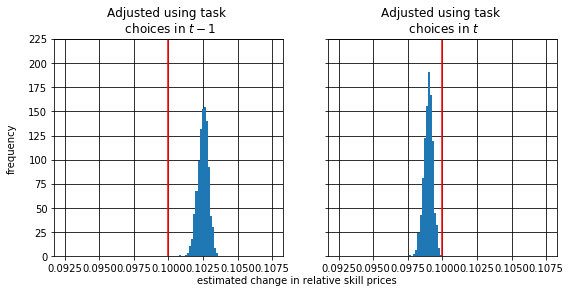

In [124]:
# plt.rc('axes', axisbelow=True)
# plt.xticks(rotation=45)
# plt.xlabel("estimated change in relative skill prices")
# plt.ylabel("frequency")
# plt.rc('grid', linestyle="-", color='black')
# plt.grid(True)
title = "Adjusted using task \n choices in {}"


fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
# add histograms
axs[0].hist(adj_wage_on_mean_lmb_previous, bins=100, range=(0.0925, .1075))
axs[1].hist(adj_wage_on_mean_lmb_concurrent, bins=100, range=(0.0925, .1075))
# add vertical line at true change in skill prices
axs[0].plot([0.1, 0.1], [0, 225], color='r')
axs[1].plot([0.1, 0.1], [0, 225], color='r')
# limit y axis
axs[0].set_ylim(225), axs[1].set_ylim(0, 225)
# enable grids
axs[0].grid(), axs[1].grid()
# add subplot titles
axs[0].set_title(title.format("$t-1$")), axs[1].set_title(title.format("$t$"))
# label axes
fig.text(0.5, 0.04, 'estimated change in relative skill prices', ha='center', va='center')
fig.text(0.06, 0.5, 'frequency', ha='center', va='center', rotation='vertical')
# set figsize
fig.set_figwidth(9)
# plt.show()
# plt.hist(adj_wage_on_mean_lmb, bins=100, range=(0.09, .11))
plt.savefig("..//latex_files\\FIG\\MC_estimation_rslt.png", dpi=450)

In [70]:
adj_wage_on_mean_lmb_concurrent

array([0.102554, 0.102554, 0.102554, 0.102554, 0.102554, 0.102554,
       0.102554, 0.102554, 0.102554, 0.102554, 0.102554, 0.102554,
       0.102554, 0.102554, 0.102554, 0.102554, 0.102554, 0.102554,
       0.102554, 0.102554, 0.102554, 0.102554, 0.102554, 0.102554,
       0.102554, 0.102554, 0.102554, 0.102554, 0.102554, 0.102554,
       0.102554, 0.102554, 0.102554, 0.102554, 0.102554, 0.102554,
       0.102554, 0.102554, 0.102554, 0.102554, 0.102554, 0.102554,
       0.102554, 0.102554, 0.102554, 0.102554, 0.102554, 0.102554,
       0.102554, 0.102554, 0.102554, 0.102554, 0.102554, 0.102554,
       0.102554, 0.102554, 0.102554, 0.102554, 0.102554, 0.102554,
       0.102554, 0.102554, 0.102554, 0.102554, 0.102554, 0.102554,
       0.102554, 0.102554, 0.102554, 0.102554, 0.102554, 0.102554,
       0.102554, 0.102554, 0.102554, 0.102554, 0.102554, 0.102554,
       0.102554, 0.102554, 0.102554, 0.102554, 0.102554, 0.102554,
       0.102554, 0.102554, 0.102554, 0.102554, 0.102554, 0.102

Get a heatmap of the correlations coefficients for task choices and their squares in the base period.

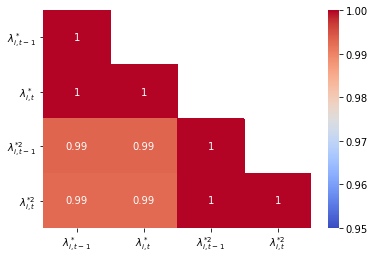

In [282]:
    corr = exog_base[["lmb_0", "lmb_1", "lmb_0^2", "lmb_1^2"]].corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask, k=1)] = True
    fig = sns.heatmap(
        data=corr,
        vmin=0.95,
        vmax=1.0,
        annot=True,
        mask=mask,
        xticklabels=["$\lambda_{i,t-1}^*$", "$\lambda_{i,t}^*$", "$\lambda_{i,t-1}^{*2}$", "$\lambda_{i,t}^{*2}$"],
        cmap="coolwarm"
        )
    fig.set_yticklabels(rotation=0, labels=["$\lambda_{i,t-1}^*$", "$\lambda_{i,t}^*$", "$\lambda_{i,t-1}^{*2}$", "$\lambda_{i,t}^{*2}$"])
    fig.get_figure().savefig("latex_files\\FIG\\corr_heatmap.png", dpi=450)

Get a scatterplot of all simulated combinations of optimal task choices and realized wages with histograms on both axes for one MC iteration (particularly, in the way this is currently set up, for the last MC iteration).

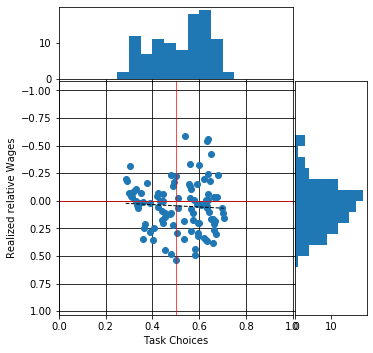

In [20]:
choices = sim_data.loc[idx[0, :], "lambda"].values
wages = sim_data.loc[idx[0, :], "wage"].values


def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y)

    # now determine nice limits by hand:
    binwidth = 0.1
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    xbins = np.arange(0, lim + binwidth, binwidth/2)
    ybins = np.arange(-lim, lim + binwidth, binwidth)
    
    ax_histx.hist(x, bins=xbins)
    ax_histy.hist(y, bins=ybins, orientation='horizontal')
    
    #ax_vline.plot([0.5, 0.5], [-lim, lim], color='black', lw=.7)
    
    

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(5, 5))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# use the previously defined function
scatter_hist(choices, wages, ax, ax_histx, ax_histy)

# vertical line
ax.plot([0.5, 0.5], [wages.max()+.5, wages .min()-.5], color='r', lw=.7)
# horizontal line
ax.plot([0, 1], [0, 0], color='r', lw=.7)
ax.set_xlim(0,1)
ax.set_ylim(wages.max()+.5, wages.min()-.5)
ax.set_xlabel("Task Choices")
ax.set_ylabel("Realized relative Wages")

# add regression line
m, b = np.polyfit(choices.astype(float), wages.astype(float), 1)
ax.plot(np.sort(choices), m*np.sort(choices)+b, linestyle="--", lw=1, color="black")


ax.grid(True)
#plt.savefig("MC_simulation\\FIG\\simulated_data.png", dpi=450)
# plt.savefig("latex_files\\FIG\\simulated_data.png", dpi=450, bbox_inches='tight')
plt.show()
